In [19]:
file_path = "explanations/graph_Synth_wheel_cube_GCN_GraphMaskExplainer/2024-07-29-22-24-15/complexes_metrics.json"

In [20]:
import json

with open(file_path, "r") as f:
    data = json.load(f)

print(data.keys())

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])


In [21]:
from pprint import pprint
best_per_seed = []

# get best per seed for each combo of hyperparameters prop_method, alpha_c, alpha_e
hp_combos = set()
prop_methods = set()
per_hp_metrics = {}
for seed in data.keys():
    metrics = data[seed]

    # metrics is a list of dicts
    for metric in metrics:
        prop_method = metric["prop_method"]
        alpha_c = metric["alpha_c"]
        alpha_e = metric["alpha_e"]
        
        prop_methods.add(prop_method)

        hp_combos.add((prop_method, alpha_c, alpha_e))
        
        if (prop_method, alpha_c, alpha_e) not in per_hp_metrics:
            per_hp_metrics[(prop_method, alpha_c, alpha_e)] = []
        
        per_hp_metrics[(prop_method, alpha_c, alpha_e)].append(metric)
        
pprint(per_hp_metrics)

{('direct_prop', 0, 0): [{'accuracy': 0.5156626644963418,
                          'alpha_c': 0,
                          'alpha_e': 0,
                          'auc': 0.49810838843762684,
                          'f1': 0.25849811679694623,
                          'jaccard': 0.18289600437486497,
                          'precision': 0.1967520393262771,
                          'prop_method': 'direct_prop',
                          'recall': 0.3950595238095238},
                         {'accuracy': 0.510533706318207,
                          'alpha_c': 0,
                          'alpha_e': 0,
                          'auc': 0.49664468753444474,
                          'f1': 0.27627668686270734,
                          'jaccard': 0.19276605315039683,
                          'precision': 0.22355005815168696,
                          'prop_method': 'direct_prop',
                          'recall': 0.40315476190476196},
                         {'accuracy': 0.507092291

In [22]:
# get the avg
avg_per_hp = {}
for hp in per_hp_metrics.keys():
    metrics = per_hp_metrics[hp]
    
    avg = {}
    for metric in metrics:
        for key in metric.keys():
            if key in ["prop_method", "alpha_c", "alpha_e"]:
                continue
            if key not in avg:
                avg[key] = 0
            print(metric[key])
            avg[key] += metric[key]
    
    for key in avg.keys():
        avg[key] /= len(metrics)
    
    avg_per_hp[hp] = avg
    
pprint(avg_per_hp)

0.49971901622964837
0.5410279651874808
0.5851785714285718
0.5132760322179464
0.39940498507264105
0.5132406160352635
0.4598635110836398
0.4732964820232951
0.6016666666666667
0.48372018386941507
0.36331868173489085
0.47974198175629745
0.5252555875866329
0.5505265979537821
0.6242261904761903
0.538492065533113
0.41646253749870255
0.5387654998510263
0.4327820742909298
0.4723359917196205
0.6121428571428572
0.4932475304754997
0.3720211878877929
0.46019644404984783
0.5324151110400309
0.5721750002979135
0.6537499999999998
0.56482737697524
0.447526200808951
0.5482546504601425
0.4935885001166497
0.5340488477374966
0.6535714285714285
0.5404236448145777
0.4158811644525543
0.5129123715691811
0.4968713692710232
0.5389753734876482
0.6742857142857142
0.5511658109053663
0.4230572082165775
0.5162244915812229
0.4947179739737719
0.540158375758336
0.5885714285714286
0.5191675951445079
0.39414041585297993
0.501672410192147
0.43214441668685166
0.44902217590414734
0.6602976190476191
0.5068817360739061
0.379614

In [23]:
# plot the avg for each hp combo on the same plot

# x axis is the hp combo, y axis is the score, and we plot the score for each metric acc, f1, etc. and the legend is the metric name

from collections import defaultdict
import matplotlib.pyplot as plt

x = list(avg_per_hp.keys())
print(len(x))
ys = {}
for metric in avg_per_hp[x[0]].keys():
    print(metric)
    y = [avg_per_hp[hp][metric] for hp in x]
    print(len(y))
    ys[metric] = y
 
# get best  performing metrics for each prop_method based on jaccard

best_per_prop_method = {}
for prop_method in prop_methods:
    best_per_prop_method[prop_method] = {}
    
    # order the metrics by jaccard
    jaccards = []
    for hp in x:
        if hp[0] == prop_method:
            jaccards.append((hp, avg_per_hp[hp]["jaccard"]))
    
    jaccards = sorted(jaccards, key=lambda x: x[1], reverse=True)
    
    print(jaccards)
    
    best_per_prop_method[prop_method] = avg_per_hp[jaccards[0][0]]
    
pprint(best_per_prop_method)

64
accuracy
64
precision
64
recall
64
f1
64
jaccard
64
auc
64
[(('direct_prop', 1.5, 1.0), 0.3456553604683963), (('direct_prop', 1.5, 1.5), 0.3456553604683963), (('direct_prop', 1.5, 0.5), 0.3441289024306241), (('direct_prop', 1.5, 0), 0.3432334190126555), (('direct_prop', 1.0, 1.0), 0.33175938511863345), (('direct_prop', 1.0, 1.5), 0.33175938511863345), (('direct_prop', 1.0, 0.5), 0.33114599608009254), (('direct_prop', 0.5, 0), 0.3283579845504553), (('direct_prop', 1.0, 0), 0.3280511711976573), (('direct_prop', 0.5, 0.5), 0.32709929241964864), (('direct_prop', 0.5, 1.5), 0.32696353384616383), (('direct_prop', 0.5, 1.0), 0.32673129009686663), (('direct_prop', 0, 1.0), 0.24955915941914525), (('direct_prop', 0, 1.5), 0.24955915941914525), (('direct_prop', 0, 0.5), 0.2493216961851905), (('direct_prop', 0, 0), 0.2027375520940753)]
[(('entropy_based_propagation', 0, 0.5), 0.3122803866066358), (('entropy_based_propagation', 0, 0), 0.2685444842502319), (('entropy_based_propagation', 0, 1.0), 

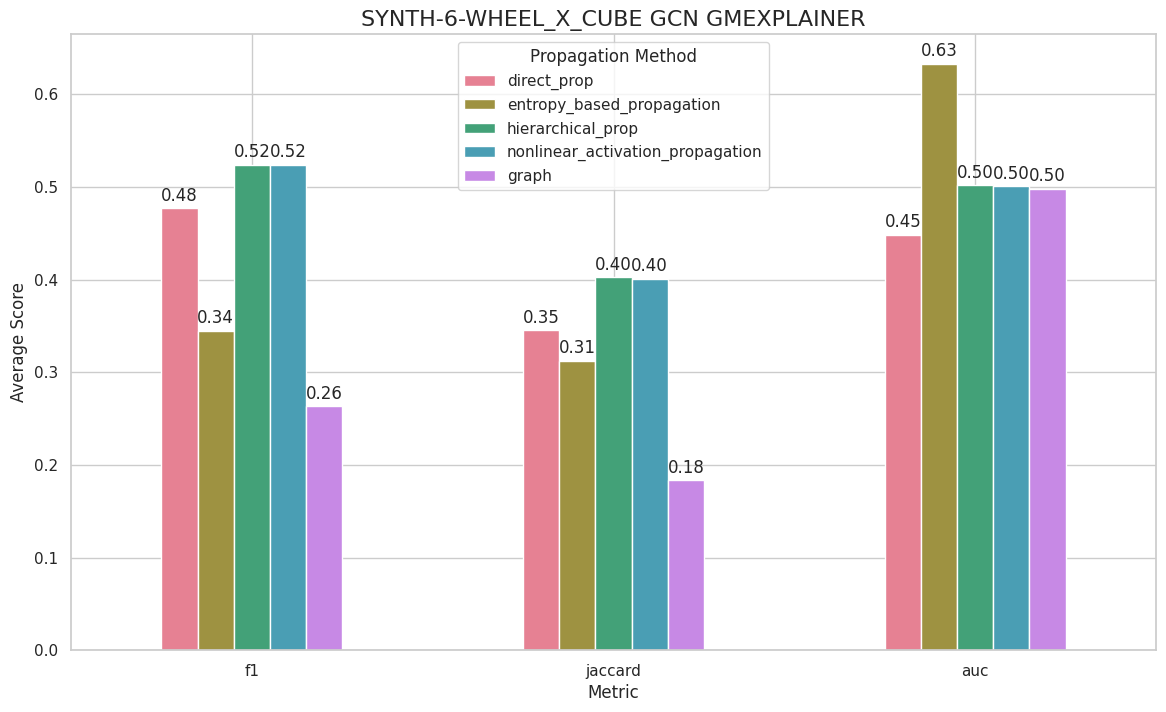

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Sample data
data = best_per_prop_method

data["graph"] = {
        "accuracy": 0.5115135806197763,
        "precision": 0.21791443452754936,
        "recall": 0.3894940476190476,
        "f1": 0.2634409031266071,
        "jaccard": 0.18347176115579578,
        "auc": 0.4981550051538887,
    }
# Convert data to a suitable format for Seaborn
df_data = []
for prop_method, metrics in data.items():
    for metric_name, values in metrics.items():
        if metric_name in ["accuracy", "precision", "recall"]:
            continue
        df_data.append(
            {
                "Propagation Method": prop_method,
                "Metric": metric_name,
                "Average Score": values,
            }
        )

df = pd.DataFrame(df_data)

sns.set(style="whitegrid")  # Set the Seaborn style

# fill the "graph" bars with a different style

plt.figure(figsize=(14, 8))  # Set the figure size
barplot = sns.barplot(
    x="Metric",
    y="Average Score",
    hue="Propagation Method",
    data=df,
    palette="husl",
    capsize=0.1,
    width=0.5,
)

plt.xlabel("Metric")
plt.ylabel("Average Score")
plt.title("SYNTH-WHEEL_X_CUBE GCN GMEXPLAINER", fontsize=16)
plt.legend(title="Propagation Method")
plt.grid(True)
# plt.tight_layout()  # Adjust the layout

# add the actual values on top of the bars
for p in barplot.patches:
    if p.get_height() <= 0:
        continue
    barplot.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

plt.show()